### Import dependencies

In [167]:
from nilearn import plotting, image
import matplotlib.pyplot as plt
%matplotlib inline

# Get the Node and Workflow object
from nipype import Node, Workflow, Function

# Specify which SPM to use
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12-r7219/spm12_mcr/spm12')
from nipype.algorithms.misc import Gunzip

# set up FSL environment
import os
output_dir = './output'
os.makedirs(output_dir, exist_ok=True)
os.environ['FSLDIR'] = '/usr/local/fsl' # set the FSL directory
os.environ['PATH'] = f"{os.environ['FSLDIR']}/bin:{os.environ['PATH']}" # add FSL to the PATH
os.environ['FSLOUTPUTTYPE'] = 'NIFTI' # set the output type

In [168]:
# initialize the functional file sample
func_file = '/Users/jaslavie/fMRI/data/ds102_R2.0.0/sub-07/func/sub-07_task-flanker_run-1_bold.nii.gz'

# Initiate Gunzip node to decompress the file
gunzip_func = Node(Gunzip(in_file=func_file), name='gunzip_func')

### visualize and clean data

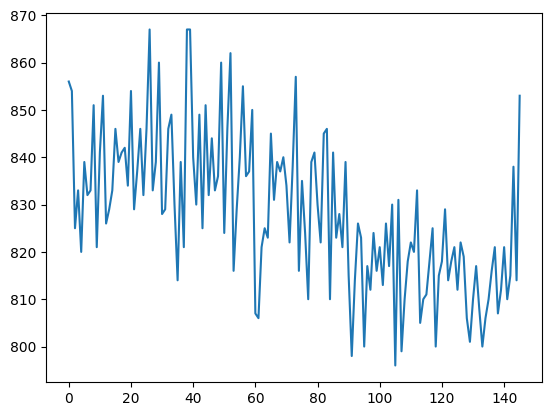

In [169]:
# plot a test voxel
import nibabel as nb
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(nb.load(func_file).get_fdata()[32, 32, 15, :])

In [170]:
# filter out outlier signals

# Create workflow
preproc = Workflow(name='preproc_workflow', base_dir='./output')

# Initiate Gunzip node to decompress the file
gunzip_func = Node(Gunzip(in_file=func_file), name='gunzip_func')

# Extract ROI using nilearn instead of FSL
from nilearn.image import index_img

def extract_roi(in_file, t_min=4):
    from nilearn import image 
    from nilearn.image import index_img 
    img = image.load_img(in_file)
    roi_img = index_img(img, slice(t_min, None))
    return roi_img # return the extracted ROI img

extract = Node(
    Function(
        input_names=['in_file', 't_min'],
        output_names=['roi_img'],
        function=extract_roi
    ),
    name='extract'
)
extract.inputs.t_min = 4

In [174]:
# slice time correction (temporal alignment)
from nipype.interfaces.spm import SliceTiming

# First, remove any existing node to avoid conflicts
if preproc.get_node('slicetime_correction'):
    preproc.remove_nodes(['slicetime_correction'])

# Create slice order for interleaved acquisition
slice_order = list(range(1, 31, 2)) + list(range(2, 31, 2))

# Create the slice timing correction node
slicetime = Node(
    SliceTiming(
        num_slices=30,
        time_repetition=2.5,
        time_acquisition=2.5,  # Changed this
        slice_order=slice_order,
        ref_slice=1
    ),
    name='slicetime_correction'
)

# Connect nodes
preproc.connect([
    (gunzip_func, extract, [('out_file', 'in_file')]),
    (extract, slicetime, [('roi_img', 'in_file')])
])

# Run workflow
try:
    preproc.run()
    corrected_img = list(preproc.get_node('slicetime_correction').outputs.items())[0][1]
    plotting.plot_epi(corrected_img, title='Slice-time corrected image')
    plt.show()
except Exception as e:
    print(f"An error occurred: {str(e)}")

241107-23:18:00,748 nipype.workflow INFO:
	 Workflow preproc_workflow settings: ['check', 'execution', 'logging', 'monitoring']
241107-23:18:00,763 nipype.workflow INFO:
	 Running serially.
241107-23:18:00,764 nipype.workflow INFO:
	 [Node] Setting-up "preproc_workflow.gunzip_func" in "/Users/jaslavie/fMRI/output/preproc_workflow/gunzip_func".
241107-23:18:00,767 nipype.workflow INFO:
	 [Node] Cached "preproc_workflow.gunzip_func" - collecting precomputed outputs
241107-23:18:00,768 nipype.workflow INFO:
	 [Node] "preproc_workflow.gunzip_func" found cached.
241107-23:18:00,768 nipype.workflow INFO:
	 [Node] Setting-up "preproc_workflow.extract" in "/Users/jaslavie/fMRI/output/preproc_workflow/extract".
241107-23:18:01,191 nipype.workflow INFO:
	 [Node] Cached "preproc_workflow.extract" - collecting precomputed outputs
241107-23:18:01,191 nipype.workflow INFO:
	 [Node] "preproc_workflow.extract" found cached.
241107-23:18:01,195 nipype.workflow INFO:
	 [Node] Setting-up "preproc_workflo